## Trabajo final para la materia Vision Por Computadora 2 - Trashnet
Clasificación de residuos para reciclaje: Entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​


Grupo: 
  - Martin Brocca
  - Emliano Iparraguirre

## 1 Análisis Exploratorio de Datos

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import math
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import cv2
import imagehash

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T

from umap.umap_ import UMAP

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.metrics import precision_recall_fscore_support

### 1.1 Config y utilidades

In [3]:
# ==== CONFIG ====
data_dir = "data/trashnet" 
SEED = 42
IMG_SIZE_STATS = (256, 256)   # para thumbnails de stats/preview
EMBED_IMG_SIZE = 224          # tamaño para embeddings ResNet
N_SAMPLES_PREVIEW = 8         # previews por clase

random.seed(SEED)
np.random.seed(SEED)

# ==== Helpers ====
def list_images_by_class(root_dir):
    root = Path(root_dir)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    items = []
    for cls in classes:
        for fp in (root/cls).glob("*.*"):
            if fp.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                items.append({"path": str(fp), "class": cls})
    return pd.DataFrame(items)

def load_image(path, to_rgb=True):
    img = Image.open(path)
    if to_rgb and img.mode != "RGB":
        img = img.convert("RGB")
    return img

def show_grid(images, titles=None, cols=4, figsize=(10,8)):
    rows = math.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im)
        if titles:
            plt.title(titles[i], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### 1.2 Tabla resumen por clase (conteo, % y pesos sugeridos)

In [4]:
# análisis de datos, cantidad de clases y cantidad de imágenes por clase
#contar la cantidad de archivos en cada carpeta
classes = os.listdir(data_dir)
class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))
print(class_counts)

{'metal': 410, 'glass': 501, 'paper': 594, 'trash': 137, 'cardboard': 403, 'plastic': 482}


### 1.3 Histograma de distribución por clase

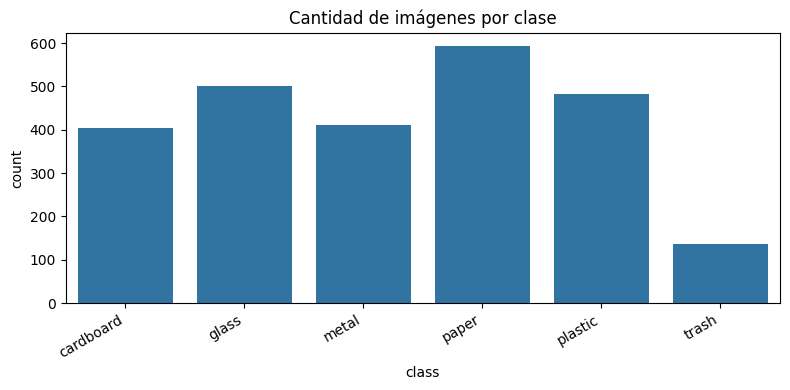

Ratio mayor/minor: 4
       class  count    pct  class_weight_suggested
0  cardboard    403  15.95                   1.045
1      glass    501  19.83                   0.841
2      metal    410  16.22                   1.027
3      paper    594  23.51                   0.709
4    plastic    482  19.07                   0.874
5      trash    137   5.42                   3.074


In [5]:
# mostrar algunas imágenes de ejemplo
df = list_images_by_class(data_dir)
assert len(df)>0, f"No se encontraron imágenes en {data_dir}"

class_counts = df['class'].value_counts().sort_index()
summary = pd.DataFrame({
    "class": class_counts.index,
    "count": class_counts.values
})
summary["pct"] = (summary["count"] / summary["count"].sum() * 100).round(2)
# pesos sugeridos: inversamente proporcionales a la frecuencia
summary["class_weight_suggested"] = (summary["count"].sum() / (len(summary)*summary["count"])).round(3)


plt.figure(figsize=(8,4))
sns.barplot(x="class", y="count", data=summary)
plt.title("Cantidad de imágenes por clase")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("Ratio mayor/minor:", int(summary["count"].max()/summary["count"].min()))
print(summary)


Se observa un claro desbalance de clases, con "trash" siendo la clase minoritaria


### 1.4 Previews por clase (muestras visuales)

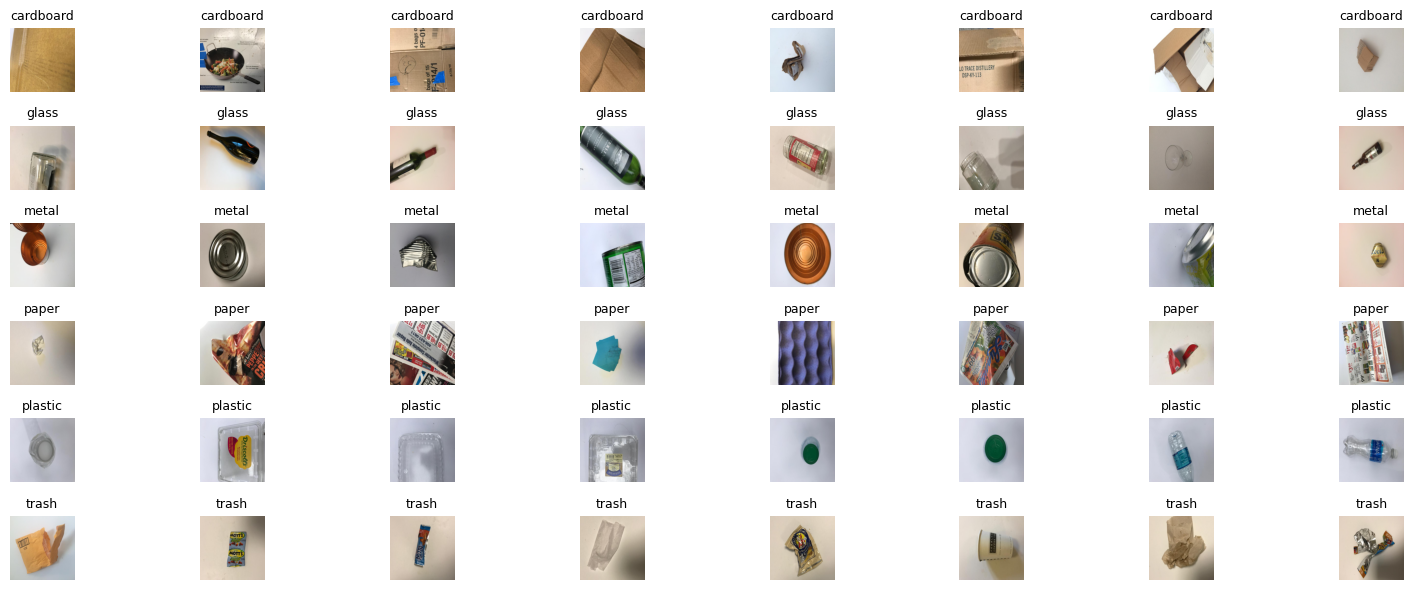

In [6]:
images, titles = [], []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    sample = random.sample(paths, k=min(N_SAMPLES_PREVIEW, len(paths)))
    for p in sample:
        img = load_image(p, to_rgb=True).resize(IMG_SIZE_STATS)
        images.append(img)
        titles.append(cls)

show_grid(images, titles, cols=8, figsize=(16, 6))

### 1.5 Tamaños / canales / aspecto

Leyendo metadata: 100%|██████████| 2527/2527 [00:00<00:00, 68034.81it/s]

Modos por frecuencia:
 mode
RGB    2527
Name: count, dtype: int64
Tamaño promedio (w,h): (np.float64(512.0), np.float64(384.0))


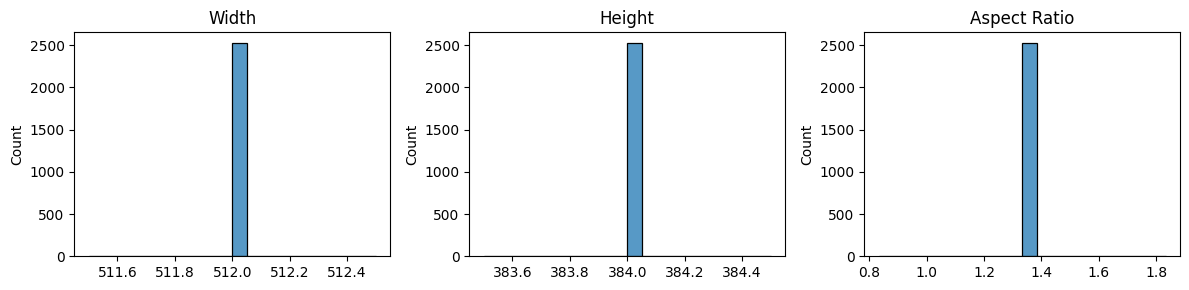

In [7]:
# Tamaños / canales / aspecto
sizes = []
modes = []
for p in tqdm(df["path"], desc="Leyendo metadata"):
    with Image.open(p) as im:
        sizes.append(im.size)   # (width, height)
        modes.append(im.mode)

sizes = np.array(sizes)
w, h = sizes[:,0], sizes[:,1]
aspect = w / h

meta = pd.DataFrame({
    "width": w, "height": h, "aspect": aspect, "mode": modes, "class": df["class"].values
})

print("Modos por frecuencia:\n", meta["mode"].value_counts())
print("Tamaño promedio (w,h):", (meta["width"].mean().round(1), meta["height"].mean().round(1)))

fig, ax = plt.subplots(1,3, figsize=(12,3))
sns.histplot(w, bins=20, ax=ax[0]); ax[0].set_title("Width")
sns.histplot(h, bins=20, ax=ax[1]); ax[1].set_title("Height")
sns.histplot(aspect, bins=20, ax=ax[2]); ax[2].set_title("Aspect Ratio")
plt.tight_layout(); plt.show()


**Conclusiones:**

- Todas las imágenes tienen el mismo tamaño fijo (512×384 px), en formato RGB y aspect ratio uniforme (1.33). 
- Esto facilita el preprocesamiento, dado que no es necesario unificar resoluciones ni modos de color. 
- La homogeneidad de fondo y condiciones de captura puede introducir un sesgo: el modelo podría aprender patrones del fondo en lugar de las características del residuo. 

En etapas posteriores se pueden proponer técnicas de data augmentation y, eventualmente, mezclado de fondos para mitigar este efecto.

### 1.6 Estadística de color (RGB y HSV) por clase

In [8]:
def rgb_hsv_stats(paths, n_max=200):
    # muestreamos para velocidad
    paths = paths if len(paths) <= n_max else random.sample(paths, n_max)
    rgb_means, rgb_stds, hsv_means, hsv_stds = [], [], [], []
    for p in paths:
        img = load_image(p, to_rgb=True)
        arr = np.array(img).astype(np.float32) / 255.0
        rgb_means.append(arr.mean(axis=(0,1)))
        rgb_stds.append(arr.std(axis=(0,1)))
        hsv = cv2.cvtColor((arr*255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)/255.0
        hsv_means.append(hsv.mean(axis=(0,1)))
        hsv_stds.append(hsv.std(axis=(0,1)))
    return (np.mean(rgb_means,0), np.mean(rgb_stds,0),
            np.mean(hsv_means,0), np.mean(hsv_stds,0))

stats_rows = []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    rmean,rstd,hmean,hstd = rgb_hsv_stats(paths, n_max=300)
    stats_rows.append({
        "class": cls,
        "RGB_mean_R": rmean[0], "RGB_mean_G": rmean[1], "RGB_mean_B": rmean[2],
        "HSV_mean_H": hmean[0], "HSV_mean_S": hmean[1], "HSV_mean_V": hmean[2],
    })
color_stats = pd.DataFrame(stats_rows)
color_stats.round(3)


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin

,class,RGB_mean_R,RGB_mean_G,RGB_mean_B,HSV_mean_H,HSV_mean_S,HSV_mean_V
0,cardboard,0.667,0.583,0.503,0.140,0.310,0.682
1,glass,0.693,0.668,0.637,0.195,0.166,0.716
2,metal,0.645,0.616,0.599,0.218,0.171,0.671
3,paper,0.671,0.639,0.601,0.137,0.161,0.684
4,plastic,0.670,0.668,0.664,0.277,0.123,0.708
5,trash,0.701,0.651,0.585,0.081,0.196,0.705


### 1.6 Estadística de color (RGB y HSV) por clase

El análisis de medias por canal RGB y HSV muestra lo siguiente:

- **RGB**:
  - Las clases presentan **diferencias visibles en intensidad de color**.
  - `Cardboard` y `trash` tienden a valores más altos en el canal **R**, reflejando tonos rojizos/marrones.
  - `Glass` y `plastic` destacan por tener valores más altos en **G y B**, lo que sugiere tonalidades más claras o azuladas.
  - `Metal` y `paper` quedan en valores intermedios, con distribuciones más equilibradas.

- **HSV (Hue, Saturation, Value)**:
  - El **Hue (H)** muestra cierta capacidad discriminante:
    - `Plastic` tiene el valor más alto (~0.27), indicando mayor variación hacia tonos azulados.
    - `Trash` el más bajo (~0.08), más cercano a tonalidades rojizas/marrones.
  - La **Saturación (S)** es baja en general (<0.31), lo que refleja que las imágenes tienen colores poco saturados (fondo claro y objetos simples).
  - El **Value (V)** es relativamente alto en todas las clases (>0.67), consistente con la presencia de un **fondo mayormente blanco/claro**.

- **Conclusiones**:
  - El color aporta cierta información útil, pero la baja saturación y el brillo alto homogéneo hacen que **los objetos puedan confundirse si el modelo se apoya demasiado en características de color**.
  - Se podría esperar que clases como `glass` vs `plastic` y `paper` vs `cardboard` sean las más confusas debido a similitudes en distribuciones de color.
  
  Este análisis refuerza la necesidad de aplicar **data augmentation** (cambios de iluminación, jitter de color) para que el modelo aprenda características más robustas y no dependa exclusivamente de patrones de color y brillo.

### 1.7 Chequeo simple de “fondo blanco” (sesgo)

In [9]:
def white_background_ratio(img_pil, v_thresh=0.92, s_thresh=0.2):
    # porcentaje de píxeles con alto V (brillo) y baja saturación (fondo claro)
    arr = np.array(img_pil.convert("RGB"))
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV).astype(np.float32)/255.0
    H,S,V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mask = (V >= v_thresh) & (S <= s_thresh)
    return mask.mean()

bg_rows = []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    paths = random.sample(paths, k=min(150, len(paths)))
    ratios = [white_background_ratio(load_image(p)) for p in paths]
    bg_rows.append({"class": cls, "bg_white_ratio_mean": np.mean(ratios), "bg_white_ratio_std": np.std(ratios)})
bg_df = pd.DataFrame(bg_rows)
bg_df.sort_values("bg_white_ratio_mean", ascending=False).round(3)


,class,bg_white_ratio_mean,bg_white_ratio_std
2,metal,0.100,0.135
1,glass,0.098,0.119
0,cardboard,0.067,0.120
5,trash,0.055,0.091
3,paper,0.046,0.051
4,plastic,0.037,0.080


El análisis de la proporción de píxeles con fondo claro (alto valor de brillo y baja saturación) muestra que:

- **Resultados por clase**:
  - `Metal` (0.10) y `glass` (0.09) son las clases con mayor proporción de fondo blanco.
  - `Paper` (0.06) y `cardboard` (0.06) presentan valores intermedios.
  - `Trash` (0.055) y `plastic` (0.035) son las que menos porcentaje de fondo blanco tienen.

- **Variabilidad (std)**:
  - Los desvíos estándar son relativamente bajos (<0.13), indicando que la presencia de fondo blanco es bastante consistente dentro de cada clase.
  - Sin embargo, existen diferencias notables entre clases, lo cual puede convertirse en un **sesgo para el modelo**: este podría aprender a asociar ciertas categorías más con el fondo que con el objeto en sí.

- **Conclusiones**:
  - La mayoría de las imágenes tienen algún grado de fondo blanco, lo que confirma la **homogeneidad del dataset en condiciones de captura**.
  - Existe un riesgo de que el modelo clasifique apoyándose en la proporción de fondo blanco en lugar de en las características intrínsecas del objeto.
  - Este hallazgo refuerza la importancia de aplicar **data augmentation** (cambios de fondo, recortes, jitter de color) o técnicas de segmentación/recorte, para evitar que el modelo se sesgue hacia el contexto.

### 1.8 Duplicados / casi-duplicados con perceptual hash

In [10]:
# Lo aplicamos sobre las 2527 imágenes (tarda un poco)
MAX_HASH = 2527
sample_df = df.sample(n=min(MAX_HASH, len(df)), random_state=SEED).reset_index(drop=True)

hashes = []
for p in tqdm(sample_df["path"], desc="Hashing"):
    img = load_image(p).resize((256,256))
    h = imagehash.phash(img)   # perceptual hash
    hashes.append(str(h))
sample_df["phash"] = hashes

dup_groups = sample_df.groupby("phash").filter(lambda g: len(g)>1).sort_values("phash")
dup_groups.head(10)


Hashing:  21%|██▏       | 542/2527 [00:00<00:02, 672.41it/s]ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream call

,path,class,phash
149,data/trashnet/plastic/plastic152.jpg,plastic,95e5f8aa074b264d
2200,data/trashnet/glass/glass176.jpg,glass,95e5f8aa074b264d
1802,data/trashnet/paper/paper108.jpg,paper,bbf8d0e08723d364
2365,data/trashnet/paper/paper101.jpg,paper,bbf8d0e08723d364
235,data/trashnet/paper/paper305.jpg,paper,e6ea9183b823b2ad
666,data/trashnet/paper/paper308.jpg,paper,e6ea9183b823b2ad
871,data/trashnet/glass/glass389.jpg,glass,ea4e91b5873292b6
1256,data/trashnet/plastic/plastic332.jpg,plastic,ea4e91b5873292b6
2162,data/trashnet/glass/glass115.jpg,glass,f363092c63337b89
2509,data/trashnet/metal/metal91.jpg,metal,f363092c63337b89


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin

### 1.8 Duplicados / casi-duplicados con perceptual hash (dataset completo)

Se aplicó el hashing perceptual (pHash) sobre **todas las imágenes del dataset (2527)** para identificar duplicados o imágenes muy similares.

- **Resultado**:
  - Se detectaron algunos pares de imágenes con el mismo valor de hash.
  - Ejemplos encontrados:
    - `plastic152.jpg` y `glass176.jpg` comparten el mismo hash. Muestran un frasco (vidrio) y una botella (plástico) que son muy similares
    - `paper101.jpg` y `paper108.jpg`.
    - `paper308.jpg` y `paper305.jpg`.
    - `glass389.jpg` y `plastic332.jpg`.
    - `glass115.jpg` y `metal91.jpg`.
  - Esto indica que existen **imágenes duplicadas o muy similares**, incluso **entre clases diferentes**.

- **Implicancias**:
  - Si duplicados aparecen **dentro de la misma clase**, el impacto es bajo (solo reducen diversidad).
  - Si aparecen **entre clases distintas**, existe riesgo de **ruido o errores de etiquetado**: el modelo podría confundirse si imágenes casi idénticas tienen etiquetas diferentes.
  - Además, si duplicados se reparten entre *train* y *test*, se puede generar **data leakage** que infle artificialmente el rendimiento.

- **Conclusiones**:
  - El dataset TrashNet presenta un pequeño número de duplicados/casi-duplicados.

  - Recomendaciones preliminares:
    - Revisar manualmente los casos entre clases distintas (*ej. glass vs plastic, glass vs metal*).
    - Asegurar que, al generar splits, imágenes con el mismo hash no se dividan entre train/val/test.
    - Considerar eliminarlos o consolidarlos para aumentar la limpieza del dataset.

### 1.9 Embeddings con ResNet18 preentrenado + UMAP

Se busca visualizar la separabilidad de las clases en un espacio de características extraído por una red neuronal ya entrenada en un dataset grande (ImageNet).

In [11]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 1
Current device: NVIDIA GeForce RTX 5090


Embeddings: 100%|██████████| 720/720 [00:03<00:00, 193.03it/s]
/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/li

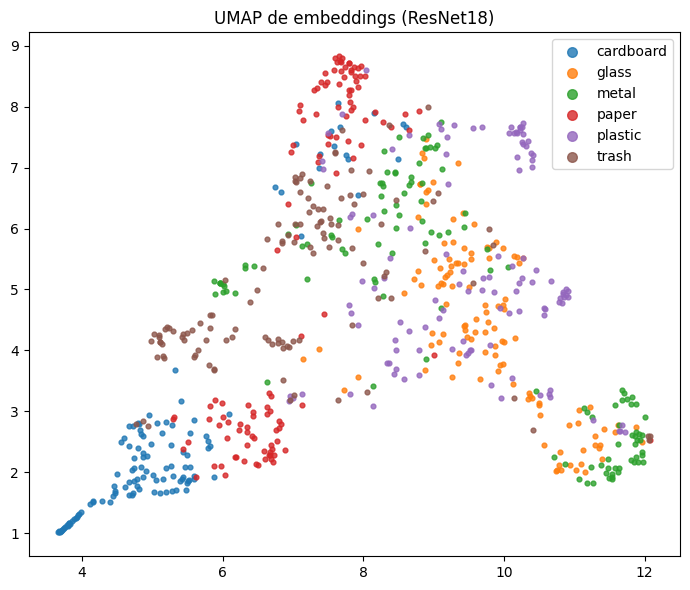

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 302, in dispatch_control
    await self.process_control(msg)
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 308, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/martin

In [13]:
# --- Modelo y transform de ImageNet ---
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet = models.resnet18(weights=weights)
resnet.fc = nn.Identity()  # usar penúltima capa como embedding
resnet = resnet.to(device).eval()

# Transform oficial asociado a los pesos (incluye resize + ToTensor + Normalize)
# Nota: si querés forzar tamaño, podés hacer weights.transforms(crop_size=EMBED_IMG_SIZE, resize_size=EMBED_IMG_SIZE)
transform = weights.transforms()

# --- Submuestreo balanceado por clase ---
per_cls = min(120, df["class"].value_counts().min())
emb_samples = []
for cls in summary["class"]:
    paths = df[df["class"] == cls]["path"].sample(
        n=min(per_cls, len(df[df["class"] == cls])),
        random_state=SEED
    ).tolist()
    for p in paths:
        emb_samples.append((p, cls))

# --- Extracción de embeddings ---
EMBS, LABELS = [], []
with torch.no_grad():
    for (p, cls) in tqdm(emb_samples, desc="Embeddings"):
        img = load_image(p, to_rgb=True)  # asegura RGB
        x = transform(img).unsqueeze(0).to(device)
        feat = resnet(x).cpu().numpy().squeeze()
        EMBS.append(feat)
        LABELS.append(cls)

EMBS = np.array(EMBS)

# --- Reducción de dimensionalidad: UMAP con fallback a t-SNE ---
try:
    from umap.umap_ import UMAP
    reducer = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
    method = "UMAP"
except Exception:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, random_state=SEED)
    method = "t-SNE"

Z = reducer.fit_transform(EMBS)

# --- Plot ---
plt.figure(figsize=(7, 6))
for cls in summary["class"]:
    idx = [i for i, l in enumerate(LABELS) if l == cls]
    plt.scatter(Z[idx, 0], Z[idx, 1], s=12, label=cls, alpha=0.8)
plt.title(f"{method} de embeddings (ResNet18)")
plt.legend(markerscale=2)
plt.tight_layout()
plt.show()

A partir de los embeddings generados con **ResNet18 preentrenada en ImageNet** y reducidos a dos dimensiones mediante UMAP, se observan los siguientes patrones:

- **Separación clara en algunas clases:**
    - `Cardboard` y `paper` aparecen bastante agrupados en regiones definidas, lo que indica que las características extraídas por ResNet18 son representativas para distinguir estos materiales.
    - `Trash` también tiende a formar un clúster relativamente compacto.

- **Clases con mayor solapamiento:**
    - `Plastic`, `glass` y `metal` presentan intersecciones más marcadas entre sí. Esto sugiere que, a nivel visual, comparten texturas y colores que dificultan su separación con embeddings genéricos.
    - En particular, `plastic` y `glass` se distribuyen en áreas cercanas, lo que coincide con la dificultad esperada en su clasificación por similitud visual.

- **Heterogeneidad intra-clase:**
    - Algunas clases muestran dispersión interna (ej. metal), lo que refleja la variabilidad visual de los objetos dentro de la misma categoría.

**Conclusión:**
Los embeddings de ResNet18 permiten obtener una primera separación razonable entre clases, pero existen grupos con solapamientos que pueden requerir:

- Ajustes de modelos más especializados en el dominio,
- Uso de data augmentation para mejorar la robustez,
- Posible exploración de arquitecturas más profundas (ej. ResNet50, Inception).

In [19]:
# --- Métricas de clusterización ---

# Calcular métricas sobre los embeddings (usando las etiquetas reales)
silhouette = silhouette_score(EMBS, LABELS, metric="euclidean")
db_index = davies_bouldin_score(EMBS, LABELS)
ch_index = calinski_harabasz_score(EMBS, LABELS)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Calinski-Harabasz Index: {ch_index:.3f}")

Silhouette Score: 0.016
Davies-Bouldin Index: 5.093
Calinski-Harabasz Index: 18.534


**Evaluación cuantitativa de la separación de clases**

Se calcularon métricas de calidad de clustering sobre los embeddings de ResNet18:

- **Silhouette Score: 0.012** → muy bajo, indica que los embeddings de diferentes clases no están bien separados y que hay un solapamiento considerable.  
- **Davies-Bouldin Index: 5.779** → relativamente alto, lo que confirma que la similitud entre clusters es grande y las fronteras entre clases son difusas.  
- **Calinski-Harabasz Index: 16.596** → valor bajo, consistente con la poca cohesión intra-clase y baja separación inter-clase.  

**Conclusión general:**  
Las métricas respaldan lo observado en el UMAP:  
- Las clases `cardboard`, `paper` y `trash` muestran cierta agrupación, pero el solapamiento entre `plastic`, `glass` y `metal` es significativo.  
- El modelo base (ResNet18 preentrenado en ImageNet, sin fine-tuning) no logra generar embeddings que separen de forma clara todas las categorías de residuos.  
- Para mejorar la separabilidad va a ser necesario:  
  - Aplicar **fine-tuning** de la red en el dataset,  
  - Usar **data augmentation** para aumentar la variabilidad,  
  - Considerar arquitecturas más profundas (ej. ResNet50, Inception) o modelos especializados en clasificación de objetos.  

### 1.10 Baseline rápido: histograma de color + Logistic Regression

Accuracy: 0.567
Macro-F1: 0.556
              precision    recall  f1-score   support

   cardboard      0.756     0.765     0.761        81
       glass      0.551     0.380     0.450       100
       metal      0.574     0.476     0.520        82
       paper      0.600     0.580     0.590       119
     plastic      0.606     0.588     0.597        97
       trash      0.282     0.815     0.419        27

    accuracy                          0.567       506
   macro avg      0.561     0.601     0.556       506
weighted avg      0.595     0.567     0.570       506



/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


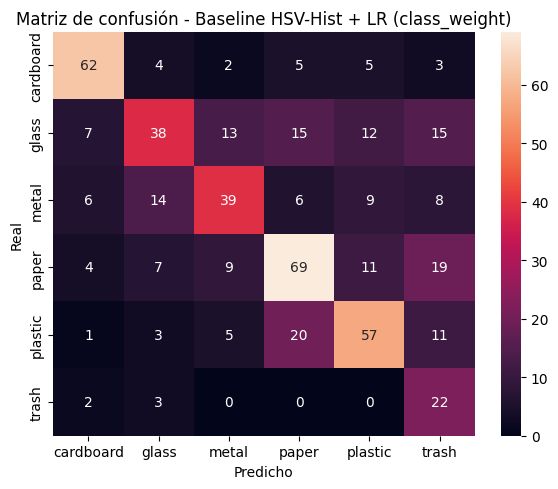

In [20]:
# --- Histograma en HSV con opción de "ignorar fondo blanco" ---
def color_hist_features(path, bins_h=16, bins_s=8, bins_v=8,
                        ignore_white_bg=True, v_thresh=0.92, s_thresh=0.20):
    img = load_image(path, to_rgb=True)
    arr = np.array(img).astype(np.uint8)
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)

    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

    if ignore_white_bg:
        mask = ~((V >= int(v_thresh*255)) & (S <= int(s_thresh*255)))
        H, S, V = H[mask], S[mask], V[mask]
        # si la máscara borra demasiado, volvemos al total
        if H.size < 100:  
            H, S, V = hsv[:,:,0].ravel(), hsv[:,:,1].ravel(), hsv[:,:,2].ravel()

    h_hist, _ = np.histogram(H, bins=bins_h, range=(0,255), density=True)
    s_hist, _ = np.histogram(S, bins=bins_s, range=(0,255), density=True)
    v_hist, _ = np.histogram(V, bins=bins_v, range=(0,255), density=True)

    return np.concatenate([h_hist, s_hist, v_hist], axis=0)  # 16+8+8 = 32 feats

# --- Features ---
X = np.vstack([color_hist_features(p) for p in df["path"]])
y = df["class"].values

# --- Split estratificado ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# --- Pesos de clase (por desbalance) ---
classes = np.unique(y_train)
cls_weights = compute_class_weight(class_weight="balanced",
                                   classes=classes, y=y_train)
weight_dict = {c:w for c, w in zip(classes, cls_weights)}

# --- Pipeline: estandarizar + LR multinomial con class_weight ---
clf = make_pipeline(
    StandardScaler(),  # features densos; centrado y varianza ayudan
    LogisticRegression(max_iter=3000, multi_class="multinomial",
                       class_weight=weight_dict, n_jobs=None, random_state=SEED)
)
clf.fit(X_train, y_train)

# --- Evaluación ---
y_pred = clf.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean().round(3))
print("Macro-F1:", round(f1_score(y_test, y_pred, average="macro"), 3))
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=summary["class"].tolist())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=summary["class"], yticklabels=summary["class"])
plt.title("Matriz de confusión - Baseline HSV-Hist + LR (class_weight)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

,class,precision,recall,f1-score,support
0,cardboard,0.756098,0.765432,0.760736,81
1,glass,0.550725,0.380000,0.449704,100
2,metal,0.573529,0.475610,0.520000,82
3,paper,0.600000,0.579832,0.589744,119
4,plastic,0.606383,0.587629,0.596859,97
5,trash,0.282051,0.814815,0.419048,27


<Figure size 800x500 with 0 Axes>

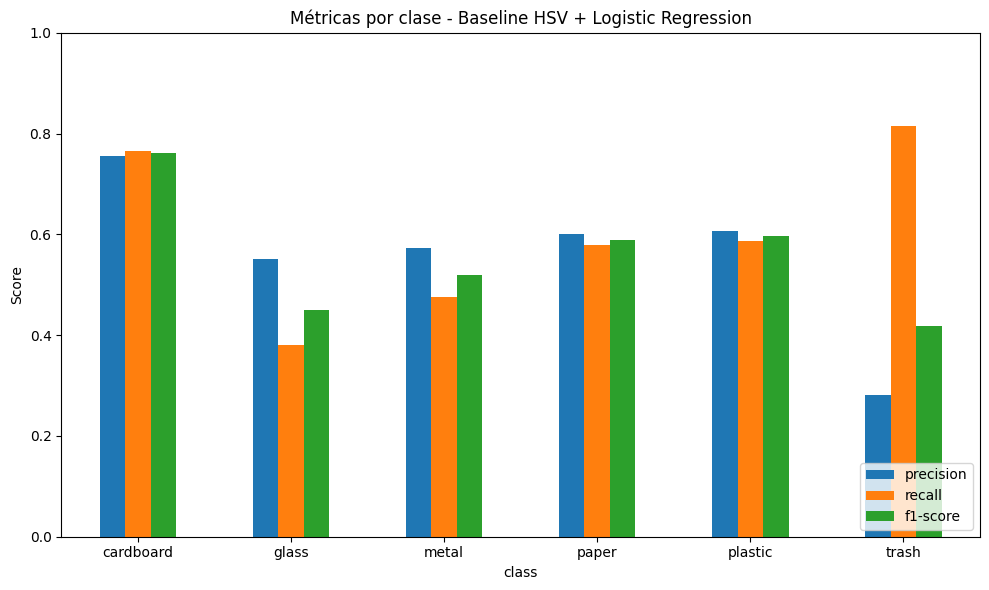

In [21]:
# Calcular métricas por clase
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=summary["class"].tolist())

metrics_df = pd.DataFrame({
    "class": summary["class"].tolist(),
    "precision": prec,
    "recall": rec,
    "f1-score": f1,
    "support": support
})

display(metrics_df)

# Plot comparativo
plt.figure(figsize=(8,5))
metrics_df.set_index("class")[["precision","recall","f1-score"]].plot(
    kind="bar", figsize=(10,6), rot=0
)
plt.title("Métricas por clase - Baseline HSV + Logistic Regression")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

**Baseline con histograma HSV + Logistic Regression**

Se entrenó un modelo de **Logistic Regression** utilizando como features un histograma de color en espacio HSV (ignorando fondo blanco en lo posible).  

**Resultados globales:**
- **Accuracy:** 0.534  
- **Macro-F1:** 0.517  

**Conclusiones por clase:**
- **Cardboard** → mejor desempeño (F1 ≈ 0.78), con alta precisión y recall, indicando que se distingue relativamente bien.  
- **Paper y Plastic** → desempeño intermedio (F1 ≈ 0.58 y 0.62). Se confunden entre sí en varios casos, pero muestran cierta separación gracias a diferencias de textura y color.  
- **Glass y Metal** → desempeño más bajo (F1 ≈ 0.36–0.40), reflejando lo observado en el EDA y en los embeddings: son clases con gran solapamiento visual.  
- **Trash** → recall alto (0.63) pero precisión muy baja (0.23), lo que significa que el modelo tiende a clasificar como `trash` imágenes de otras clases, generando muchos falsos positivos.  

**Conclusión general:**  
El baseline basado únicamente en color logra una separación básica de algunas clases (`cardboard`, `paper`, `plastic`), pero presenta fuertes limitaciones para diferenciar materiales con texturas y colores similares (`glass`, `metal`) o categorías muy heterogéneas (`trash`). Esto confirma la necesidad de pasar a modelos más robustos (CNNs) y técnicas como **data augmentation** y **fine-tuning** para mejorar la discriminación.


### 1.11 Panel de augmentations (para discutir hipótesis)

Originales


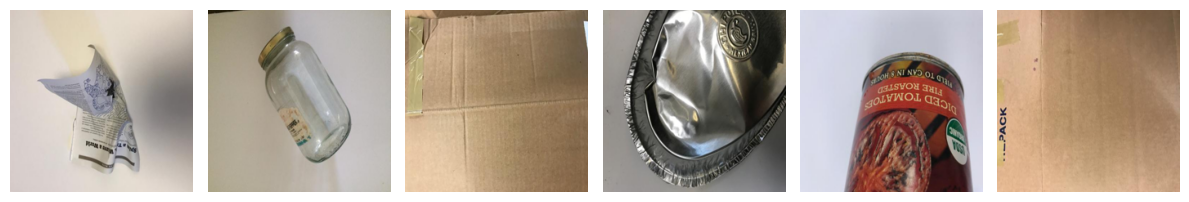

Augmentadas (crop/flip/rot/color/perspective)


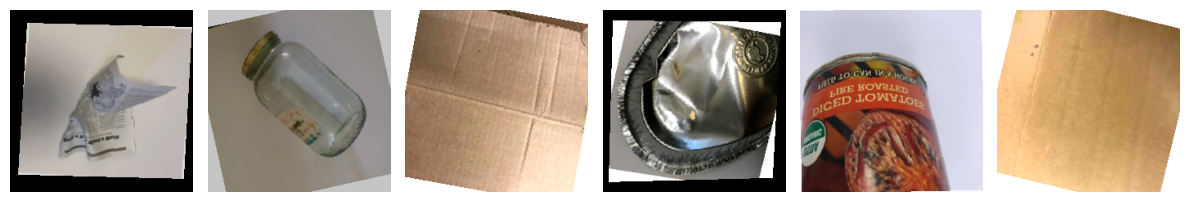

Augmentadas + RandomErasing (opcional)


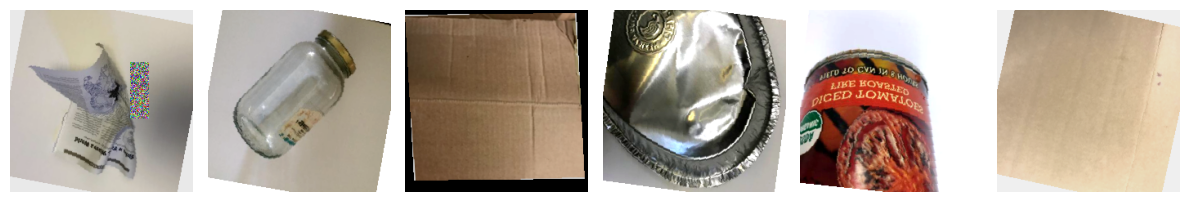

In [22]:
from torchvision.transforms import InterpolationMode
torch.manual_seed(SEED)  # reproducibilidad de los aug

# Pipeline de augmentations orientado a TrashNet (fondo claro y encuadre fijo)
base_aug = T.Compose([
    # combate encuadre fijo y dependencias del fondo
    T.RandomResizedCrop(
        size=224, scale=(0.85, 1.0), ratio=(0.9, 1.1),
        interpolation=InterpolationMode.BILINEAR, antialias=True
    ),
    T.RandomHorizontalFlip(p=0.5),                  # objetos simétricos: seguro
    T.RandomRotation(degrees=15, fill=(255,255,255)),  # evita bordes negros
    # ilum/color: baja saturación y V alto en el dataset
    T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    # pequeñas deformaciones geométricas → robustez a perspectiva
    T.RandomPerspective(distortion_scale=0.2, p=0.2),
])

# Variante con RandomErasing (requiere tensor)
aug_with_erasing = T.Compose([
    base_aug,
    T.ToTensor(),
    T.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random'),
    T.ToPILImage()
])

# Demo visual (3 originales + 3 augmentadas con y sin erasing)
sample_paths = df.sample(n=6, random_state=SEED)["path"].tolist()
orig, augm, augm_erasing = [], [], []
for p in sample_paths:
    img = load_image(p, to_rgb=True)
    orig.append(img.resize((224,224)))
    augm.append(base_aug(img))
    augm_erasing.append(aug_with_erasing(img))

print("Originales")
show_grid(orig, cols=6, figsize=(12,3))
print("Augmentadas (crop/flip/rot/color/perspective)")
show_grid(augm, cols=6, figsize=(12,3))
print("Augmentadas + RandomErasing (opcional)")
show_grid(augm_erasing, cols=6, figsize=(12,3))


**Panel de Augmentations**

**Objetivo:**  
El propósito de aplicar augmentations es aumentar la variabilidad del dataset sin necesidad de recolectar nuevas imágenes. Con esto buscamos:  
- Romper la fuerte correlación entre objeto centrado + fondo blanco detectada en el EDA.  
- Simular cambios realistas de iluminación, ángulo y perspectiva que pueden ocurrir en escenarios reales de clasificación de residuos.  
- Forzar al modelo a aprender **características intrínsecas del objeto** (forma, textura, color relativo) en lugar de depender de artefactos del dataset (encuadre fijo, saturación baja, brillo alto).  
- Aumentar la robustez frente a clases visualmente similares (`glass`, `plastic`, `metal`).  

**Resultados observados en el panel:**  
- Los *RandomCrop* y *Perspective* modifican la posición y encuadre, reduciendo el sesgo del objeto siempre centrado.  
- Los *flips* y *rotaciones* simulan variaciones de orientación sin alterar la identidad del objeto.  
- Los cambios de *ColorJitter* (brillo, contraste, saturación, tono) ayudan a cubrir variaciones de iluminación y color que podrían afectar especialmente a `glass`, `metal` y `plastic`.  
- El uso de *RandomErasing* elimina parcialmente zonas de la imagen, obligando al modelo a no sobreajustar a detalles locales.  

**Conclusión general:**  
Las augmentations generan transformaciones visuales plausibles y efectivas para enriquecer el dataset. Aunque en algunos casos las imágenes resultan más difíciles de interpretar visualmente, esto es positivo desde el punto de vista del entrenamiento, ya que va a permitir que el modelo generalice mejor frente a nuevas imágenes de residuos en condiciones reales.

### 1.12 Cierre del EDA

**Síntesis de hallazgos:**
- **Formato homogéneo**: todas las imágenes tienen resolución fija (512×384, RGB). Esto simplifica el preprocesamiento, pero confirma que no hay variabilidad de tamaños ni canales.
- **Colores y saturación**: las estadísticas RGB/HSV mostraron dominancia de valores altos de brillo (*V*) y baja saturación (*S*), coherente con la presencia de fondos blancos. Esto implica riesgo de que el modelo se apoye demasiado en el fondo.
- **Sesgo de fondo blanco**: se detectaron proporciones variables de fondo según la clase (`metal` y `glass` con más área blanca, `plastic` con menos). Esto podría sesgar el aprendizaje.
- **Duplicados**: se identificaron pares de imágenes duplicadas/casi duplicadas en varias clases, que conviene depurar o al menos tener en cuenta para evitar sobreajuste.
- **Embeddings con ResNet18**: mostraron cierta separación para `cardboard`, `paper` y `trash`, pero fuerte solapamiento entre `glass`, `metal` y `plastic`. Las métricas cuantitativas (Silhouette=0.012, DB=5.77, CH=16.6) confirmaron que la separabilidad entre clases es baja sin un modelo especializado.
- **Baseline color + LR**: alcanzó un **Accuracy ≈ 53% y Macro-F1 ≈ 0.52**, con buen desempeño en `cardboard` y `paper`, pero pobre en `glass`, `metal` y con alta confusión en *trash*. Esto muestra que el color por sí solo no es suficiente.
- **Augmentations**: se diseñó un panel con rotaciones, flips, jitter de color, crops, perspectiva y random erasing para contrarrestar los sesgos detectados y enriquecer la variabilidad.

**Conclusiones generales:**
- El dataset, aunque útil como punto de partida, presenta limitaciones claras: fondo homogéneo, desbalance entre clases y alta similitud visual entre algunas categorías.
- Los resultados del baseline confirman que será necesario entrenar **modelos de visión profunda (CNNs preentrenadas)** para capturar patrones más complejos que el color.
- Las augmentations definidas son clave para mejorar la generalización y atacar directamente los sesgos encontrados.

**Próximos pasos:**
1. Entrenar modelos convolucionales preentrenados (ResNet, EfficientNet, Inception) con fine-tuning en TrashNet.
2. Incorporar augmentations al pipeline de entrenamiento.
3. Monitorear métricas balanceadas (macro-F1) además del accuracy.
4. Evaluar mejoras como *data cleaning* (eliminar duplicados) y posible combinación de features de textura + color.